# Sub-optimal Discontinuous Current-Clamp switching rates lead to deceptive mouse neuronal firing
Marin Manuel, PhD

Université de Paris, SPPIN - Saints-Pères Paris Institute for the Neurosciences, CNRS, Paris,
France

Contact: \<firstname\> *dot* \<lastname\> *at* neurobio.org

This notebook and repository contains all the data needed to reproduce the analyses of the paper

## Imports and initialization...

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
from io import StringIO
from IPython.display import display, Markdown as md, Image
import brian2 as br
from os.path import exists
import pickle

### versions

In [2]:
for name,module in zip(['matplotlib','seaborn','numpy','pandas','brian2'],
                       [matplotlib, sns, np, pd, br]):
    print(name,':',module.__version__)

matplotlib : 3.3.1
seaborn : 0.11.0
numpy : 1.19.1
pandas : 1.1.2
brian2 : 2.4.1


In [3]:
# from https://matplotlib.org/3.1.1/gallery/misc/anchored_artists.html
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.offsetbox import (
    AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker, HPacker)

class HSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), size, 0, ec="black", lw=plt.rcParams['axes.linewidth']))

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = VPacker(children=[self.size_bar, self.txt_label],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)
        

class VSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), 0, size, ec="black", lw=plt.rcParams['axes.linewidth']))
        
        textprops = textprops or {}
        if 'rotation' not in textprops:
            textprops['rotation'] = 90

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = HPacker(children=[self.txt_label, self.size_bar],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)

# Figures

In [4]:
VmColor = 'xkcd:emerald'
ImColor = 'xkcd:royal blue'
IdccColor = 'xkcd:cerulean blue'
FreqColor = 'k'
monitorColor = 'xkcd:reddish'

### Figure-f-i-curves3

This example is cell 4109 with props:
- $R_{in}$ = 3.90 M$\Omega$
- $\tau_m$ = 4.42 ms

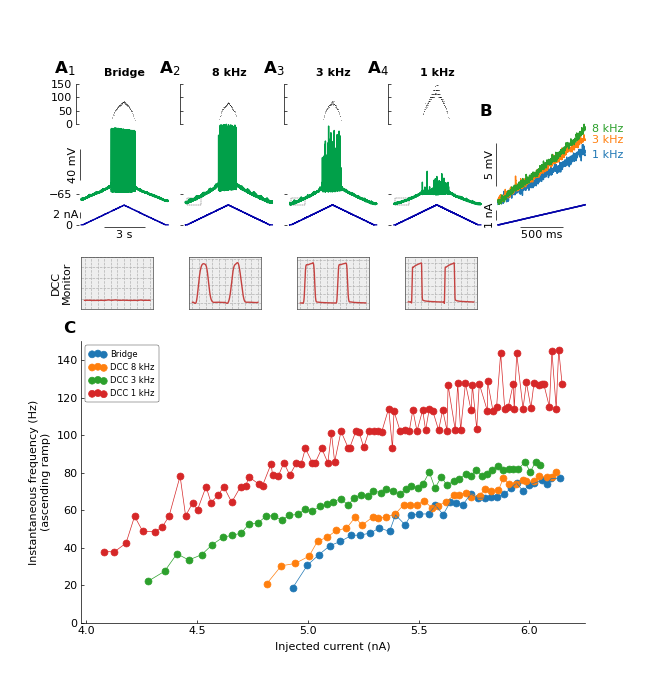

In [5]:
from matplotlib.patches import Rectangle
sTime = 0.1
eTime = sTime+1000e-3
window = 100


plt.style.use(['default','MM-paper'])


fig = plt.figure(figsize=(6.5,2+1+4), dpi=100)
gs0 = matplotlib.gridspec.GridSpec(3,1, figure=fig, 
                                   hspace=0.2, height_ratios=[2,0.75,4])
gs10 = matplotlib.gridspec.GridSpecFromSubplotSpec(3,5, subplot_spec=gs0[0], 
                                                   hspace=0, height_ratios=[1,2,0.5])
gs11 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,5, subplot_spec=gs0[1],
                                                   wspace=0.5)

axs = np.empty(shape=(3,4), dtype=np.object)
axsMon = np.empty(shape=(4,), dtype=np.object)


for i in range(3):
    for j in range(4):
        axs[i,j] = fig.add_subplot(gs10[i,j], sharey=axs[i,0], sharex=axs[0,j])
        axs[i,j].patch.set_alpha(0)
axZoomV = fig.add_subplot(gs10[1,-1])
axZoomI = fig.add_subplot(gs10[2,-1])

with plt.style.context(['MM-model',{'axes.ymargin':0.15}]):
    for j in range(4):
        axsMon[j] = fig.add_subplot(gs11[j])
    
with plt.style.context(['default',
                        'MM-paper',
                        {'axes.autolimit_mode': 'data','axes.xmargin':0.05, 'axes.ymargin':0.05}]):
    axIF = fig.add_subplot(gs0[2])
    
    
    
    
##
## TRACES
##
for file, freq, axVm, axIm in zip(['20200908_Cell4109_008_Bridge_traces.txt',
                                     '20200908_Cell4109_008_DCC8kHz_traces.txt',
                                     '20200908_Cell4109_008_DCC3kHz_traces.txt',
                                     '20200908_Cell4109_008_DCC1kHz_traces.txt',
                                     ],
                                    ['Bridge','8 kHz', '3 kHz', '1 kHz'],
                                   axs[1,:], axs[2,:]):
    df = pd.read_csv(file,sep='\t',header=0)
    axVm.plot(df['Time'],df['1 10Vm'], '-', lw=1, c=VmColor, clip_on=False)
    axIm.plot(df['Time'],df['4 Im'], '-', lw=1, c=ImColor, clip_on=False)

for file, freq, axFreq in zip(['20200908_Cell4109_008_Bridge_spikes.txt',
                               '20200908_Cell4109_008_DCC8kHz_spikes.txt',
                               '20200908_Cell4109_008_DCC3kHz_spikes.txt',
                               '20200908_Cell4109_008_DCC1kHz_spikes.txt'],
                              ['Bridge','8 kHz', '3 kHz', '1 kHz'],
                              axs[0,:]):
    times = np.loadtxt(file, skiprows=16)
    freqs = 1/np.diff(times)
    axFreq.plot(times[1:],freqs,'o',c=FreqColor,ms=0.1)
    axFreq.set_title(freq, fontsize=8)
    sns.despine(ax=axFreq, left=False, bottom=True, offset=4)
    if not axFreq.is_first_col():
        plt.setp(axFreq.get_yticklabels(), visible=False)
axs[0,0].set_ylim(0,150)
axs[0,0].set_yticks([0,50,100,150])

for ax in axs[0,:]:
    sns.despine(ax=ax, offset=4, bottom=True)
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)
for ax in axs[1,:]:
    sns.despine(ax=ax, offset=4, bottom=True)
    ax.set_yticks([-65])
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.spines['left'].set_visible(False)
for ax in axs[2,:]:
    sns.despine(ax=ax, offset=4, bottom=True)
    ax.set_yticks([0])
    ax.set_xticks([])
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.spines['left'].set_visible(False)

    
ax = axs[1,0]
v = VSizeBar(ax.transData, 40, '40 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8))
ax.add_artist(v)

ax = axs[2,0]
i = VSizeBar(ax.transData, 2, '2 nA', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8, rotation=0))
ax.add_artist(i)

t = HSizeBar(ax.transData, 3, '3 s', loc='upper center',
             pad=0, borderpad=0, sep=2,
             frameon=False,
             bbox_to_anchor=(0.5, -0.1),
             bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(t)





    
##
## ZOOM traces
##
##
for i,(file, freq) in enumerate(zip(['20200908_Cell4109_008_DCC1kHz_traces.txt',
                                     '20200908_Cell4109_008_DCC3kHz_traces.txt',
                                     '20200908_Cell4109_008_DCC8kHz_traces.txt'],
                                    ['1 kHz', '3 kHz', '8 kHz'])):
    c = f'C{i:d}'
    df = pd.read_csv(file,sep='\t',header=0)
    df2 = df.rolling(window).mean()
    df2['Time'] -= df['Time'].iloc[0]
    df2['1 10Vm'] -= df['1 10Vm'].iloc[0:window].mean()
    idx = df2.query('@sTime <= Time < @eTime').index
    axZoomV.plot(df2.loc[idx,'Time'],df2.loc[idx,'1 10Vm'], '-', lw=1, c=c, clip_on=False, label=freq)
    axZoomI.plot(df2.loc[idx,'Time'],df2.loc[idx,'4 Im'], '-', lw=1, c=ImColor, clip_on=False)
    axZoomV.annotate(freq, xy=(1,df2.loc[idx[-1],'1 10Vm']), xycoords=('axes fraction', 'data'),
                     xytext=(5,0), textcoords='offset points', va='center', color=c)

x0,x1 = axZoomV.get_xlim()
y0,y1 = axZoomV.get_ylim()
h = y1-y0
w = x1-x0
for ax in axs[1,1:]:
    x0_,_ = ax.get_xlim()
    y0_,_ = ax.get_ylim()
    rect = Rectangle(xy=(x0_+x0,y0_+y0), width=w, height=h, facecolor='none', edgecolor='k', ls='--', clip_on=False)
    ax.add_artist(rect)

for ax in [axZoomV, axZoomI]:
    sns.despine(ax=ax, bottom=True, left=True)
    sns.despine(ax=ax, bottom=True, left=True)
    ax.set_xticks([])
    ax.set_yticks([])

ax = axZoomV
v = VSizeBar(ax.transData, 5, '5 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8))
ax.add_artist(v)

ax = axZoomI
i = VSizeBar(ax.transData, 1, '1 nA', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8, rotation=90))
ax.add_artist(i)

t = HSizeBar(ax.transData, 0.5, '500 ms', loc='upper center',
             pad=0, borderpad=0, sep=2,
             frameon=False,
             bbox_to_anchor=(0.5, -0.1),
             bbox_transform=ax.transAxes,textprops=dict(fontsize=8, rotation=0))
ax.add_artist(t)
    
    
##
## DCC MONITOR
## 
for file, freq, ax in zip(['20200908_Cell4109_008_Bridge_monitor.txt',
                            '20200908_Cell4109_008_DCC8kHz_monitor.txt',
                            '20200908_Cell4109_008_DCC3kHz_monitor.txt',
                            '20200908_Cell4109_008_DCC1kHz_monitor.txt'],
                                       ['Bridge','8 kHz', '3 kHz', '1 kHz'],
                                   axsMon):
    df = pd.read_csv(file,sep='\t',header=0)
    df = df.set_index(pd.to_datetime(df['Time'], unit='s'))
    df = df.resample('1us').interpolate('quadratic', order=3)
    ax.plot(df['Time'], df['3 Monitor'], '-', lw=1, c=monitorColor)
    xmin, xmax = df['Time'].min(), df['Time'].max()
    ax.set_xticks(np.linspace(xmin,xmax,11))
    
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5, min_n_ticks=5))
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    #ax.plot([0.5],[-0.01], 'k^', ms=4, transform=ax.transAxes, clip_on=False, zorder=10)
axsMon[0].set_ylim(-25,100)
axsMon[0].set_ylabel('DCC\nMonitor', fontsize=plt.rcParams['axes.labelsize'])


    
##
## F-I Curves
##
for i,(file,freq) in enumerate(zip(['20200908_Cell4109_008_IFCurve_Bridge.txt',
                                    '20200908_Cell4109_008_IFCurve_DCC8kHz.txt',
                                    '20200908_Cell4109_008_IFCurve_DCC3kHz.txt',
                                    '20200908_Cell4109_008_IFCurve_DCC1kHz.txt'],
                                   ['Bridge','DCC 8 kHz','DCC 3 kHz','DCC 1 kHz'])):
    df = pd.read_csv(file, sep='\t', header=0)
    axIF.scatter(df.iloc[:,2], df.iloc[:,3], marker='o', lw=0.5, label=freq, clip_on=False)
    axIF.plot(df.iloc[:,2], df.iloc[:,3], '-', lw=0.5, clip_on=False)

axIF.set_xlabel('Injected current (nA)')
axIF.set_ylabel('Instantaneous frequency (Hz)\n(ascending ramp)')
axIF.legend(loc='upper left', scatterpoints=3)
axIF.set_ylim(0,150)

for l,ax in zip([f'A$_{i+1}$' for i in range(4)], axs[0,:]):
     ax.annotate(l, xy=(0,1), xycoords='axes fraction',
                 xytext=(-4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')

axZoomV.annotate('B', xy=(0,1), xycoords='axes fraction',
                 xytext=(-4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')

axIF.annotate('C', xy=(0,1), xycoords='axes fraction',
                 xytext=(-4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')

plt.show()

time base for the monitors (in µs)

In [6]:
for ax in axsMon:
    print('{:.2f}'.format(np.diff(ax.get_xticks()).mean()/1e-6))

25.00
25.00
66.00
195.50


8 kHz 8.238019999999764
3 kHz 6.992340000000013
1 kHz 5.226379999999949


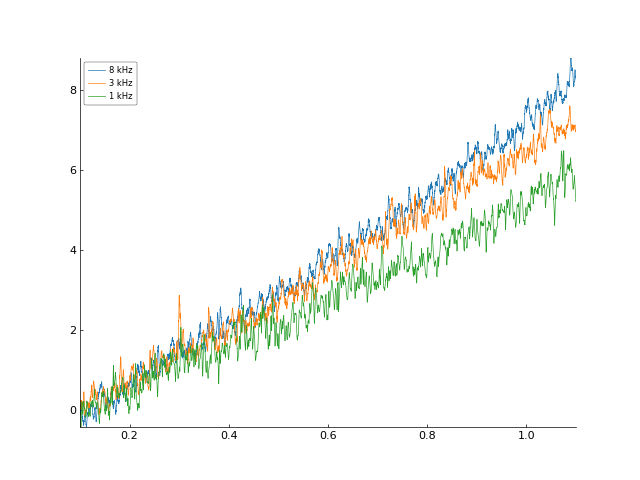

In [7]:
sTime = 0.1
eTime = sTime+1000e-3
window = 100

fig, ax = plt.subplots()

for file, freq in zip(['20200908_Cell4109_008_DCC8kHz_traces.txt',
                       '20200908_Cell4109_008_DCC3kHz_traces.txt',
                       '20200908_Cell4109_008_DCC1kHz_traces.txt',],
                      ['8 kHz', '3 kHz', '1 kHz']):
    df = pd.read_csv(file,sep='\t',header=0)
    df2 = df.rolling(window).mean()
    df2['Time'] -= df['Time'].iloc[0]
    df2['1 10Vm'] -= df['1 10Vm'].iloc[0:window].mean()
    idx = df2.query('@sTime <= Time < @eTime').index
    #temp = df
    ax.plot(df2.loc[idx,'Time'], df2.loc[idx,'1 10Vm'], label=freq)
    print(freq, df2.loc[idx[-1],'1 10Vm'])
ax.legend()
plt.show()

### Figure-summary-stats

In [8]:
summary = pd.read_csv('./Cell_summary.csv')

In [9]:
summary

,cell,Gin,DCCfreq,relDCCfreq,Ion,Ioff,ascSlope,Vthr,deltaI,deltaF,...,globalSlope,file,tauM,expDate,mouseType,mouseSex,mouseAge,mouseWeight,electrodeType,electrodeR
0,Cell4084,0.99377,8000,26.24,12.315,14.206,12.312,-60.298,1.892,19.587,...,10.683,7,3.28,2020-06-24,C57BL/6,M,169,28,KCl 3M,16
1,Cell4084,1.26544,3000,9.84,12.468,14.020,12.544,-62.810,1.552,16.937,...,11.909,7,3.28,2020-06-24,C57BL/6,M,169,28,KCl 3M,16
2,Cell4084,2.23162,1000,3.28,9.969,11.596,16.362,-70.024,1.627,-1.000,...,8.117,7,3.28,2020-06-24,C57BL/6,M,169,28,KCl 3M,16
3,Cell4090,0.72948,1000,5.12,3.165,4.066,34.262,-53.363,0.901,4.938,...,NaN,6,5.12,2020-07-01,C57BL/6,M,176,31,KCl 3M,17
4,Cell4090,0.48738,3000,15.36,3.830,4.778,9.476,-47.018,0.948,-3.191,...,NaN,6,5.12,2020-07-01,C57BL/6,M,176,31,KCl 3M,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Cell4130,0.43862,3000,10.26,6.235,7.733,19.192,-45.671,1.498,2.837,...,18.650,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25
76,Cell4130,0.34402,10000,34.20,6.230,7.782,16.362,-39.279,1.551,2.301,...,15.563,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25
77,Cell4130,0.55281,1000,3.42,4.684,6.187,56.982,-56.842,1.503,-2.786,...,50.983,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25
78,Cell4130,NaN,0,0.00,5.997,8.006,15.669,NaN,2.009,14.557,...,13.987,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25


In [10]:
summary['Rin'] = 1/summary['Gin']

In [11]:
# Normalize values to the value measured with the highest DCC freq tested
params = ['Gin','Rin','Ion', 'Ioff', 'deltaI', 'deltaF', 'ascSlope', 'descSlope','globalSlope', 'Vthr']
def norm_highest_dcc(df,params=None):
    freqs = df['DCCfreq']
    row = df.sort_values(by='DCCfreq', ascending=False).iloc[0][params]
    out = df[params]/row
    df[params] = out.astype(float)
    df['DCCfreq'] = freqs
    return df
summary_norm = summary.groupby(['cell']).apply(norm_highest_dcc, params=params)

In [12]:
# Interpolate all curves on the same "relative DCC freq"
# for averaging
from scipy import interpolate
def interpolate_relDCC(df):
    #print(df)
    x = df['relDCCfreq']
    out = pd.DataFrame(columns=df.columns)
    xx = np.arange(5, np.ceil(x.max()), 5)
    out['relDCCfreq'] = xx
    for c in params:
        y = df[c]
        f = interpolate.interp1d(x,y, fill_value='extrapolate')
        yy = f(xx)
        out[c] = np.array(yy).astype(float)
    #print(out)
    return out
        
summary_interp = summary_norm.loc[summary_norm['DCCfreq']>0].groupby('cell')[['relDCCfreq']+params].apply(interpolate_relDCC).reset_index()

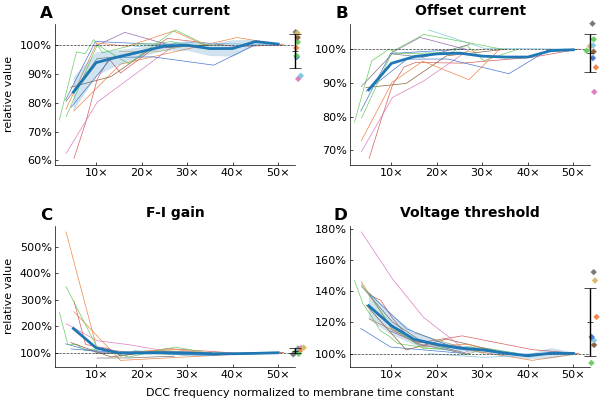

In [13]:
from collections.abc import Iterable
plt.style.use(['default','MM-paper',{'axes.xmargin':0.05, 'axes.ymargin':0.05}])

bridge_pos = 1.01
bridge_jitter = 0.01

cols = ['Ion','Ioff','ascSlope','Vthr']
labels = ['Onset current', 'Offset current', 'F-I gain', 'Voltage threshold']
n_hues = len(summary.groupby('cell'))
hues = {cell:color for cell,color in zip(summary['cell'].unique(),sns.color_palette('muted', n_colors=n_hues))}

N = len(cols)
fig, axsNorm = plt.subplots(2, 2, figsize=(6,4), dpi=100, constrained_layout=True)

for c,l,ax in zip(cols,labels,axsNorm.flat):
    sns.lineplot(data=summary_norm.loc[summary_norm.DCCfreq>0], 
                 x='relDCCfreq', y=c, 
                 hue='cell', palette=hues, ci=None,
                 ax=ax, 
                 legend=False, lw=0.5, sort=True, zorder=0, alpha=1)
    sns.lineplot(data=summary_interp,
                 x='relDCCfreq', y=c, ax=ax, legend=False, sort=True,
                 lw=2, color='C0', 
                )#ci='sd', err_style='bars', err_kws={'capsize':4, 'elinewidth':2, 'capthick':2, 'errorevery':(2,5), 'zorder':10})
    # Draw a diamond on the right side of the plot with the value
    # measured in Bridge mode as well as error bars with mean ± SD
    n = len(summary_norm[summary_norm['DCCfreq']==0].groupby('cell'))
    x = np.random.normal(loc=bridge_pos,scale=bridge_jitter,size=n)
    y = summary_norm[summary_norm['DCCfreq']==0].groupby('cell').mean()[c]
    ax.scatter(x,y,c=[hues[cell] for cell in y.index], marker='D', s=9, transform=ax.get_yaxis_transform(), clip_on=False)
    out = ax.errorbar(x=1,y=y.mean(),yerr=y.std(), transform=ax.get_yaxis_transform(), clip_on=False,
                fmt="_", capsize=4, lw=1, color='k', elinewidth=1)
    # artists in the bridge errorbars are clipped if outside the plot, this
    # sets clip_on = False on all the artists
    for a in out:
        a = [a] if not isinstance(a, Iterable) else a
        for b in a:
            b.set_clip_on(False)

    ax.axhline(1, ls='--', c='xkcd:dark grey', zorder=0)
    #ax.axvline(10, ls='--', c='xkcd:rust', lw=1)
    ax.set_title(l)
    ax.set_ylabel('')
    ax.set_xlabel(' ')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, decimals=0, symbol='×'))
    ax.set_xlim(left=1)
    if ax.is_first_col():
        ax.set_ylabel('relative value')

l2 = axsNorm[1,0].set_xlabel(' ')

for l,ax in zip('ABCDEFGHIJKL',axsNorm.flatten()):
    ax.annotate(l, xy=(0,1), xycoords='axes fraction',
                   xytext=(-2,2), textcoords='offset points',
                   ha='right', va='bottom', fontsize=12, fontweight='bold')

# Hack to get a x-label at the same place as a normal x-label would be,
# but centered in the figure
fig.canvas.draw()
bbox = l2.get_window_extent()
_,y = fig.transFigure.inverted().transform([bbox.x0,bbox.y0])
fig.text(0.5, y, 'DCC frequency normalized to membrane time constant', 
         ha='center', fontsize=plt.rcParams['axes.labelsize'], fontweight=plt.rcParams['axes.labelweight'])    
plt.show()

compare max DCC rate with Bridge

In [14]:
import dabest

>>>>> Ion <<<<<<<
DABEST v0.3.1
             
Good evening!
The current time is Tue Dec  1 22:45:10 2020.

The paired mean difference between bridge and max is 0.0963 [95%CI -0.111, 0.531].
The p-value of the two-sided permutation t-test is 0.707. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`
>>>>> Ioff <<<<<<<
DABEST v0.3.1
             
Good evening!
The current time is Tue Dec  1 22:45:10 2020.

The paired mean difference between bridge and max is 0.116 [95%CI -0.124, 0.584].
The p-value of the two-sided permutation t-test is 0.677. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s)

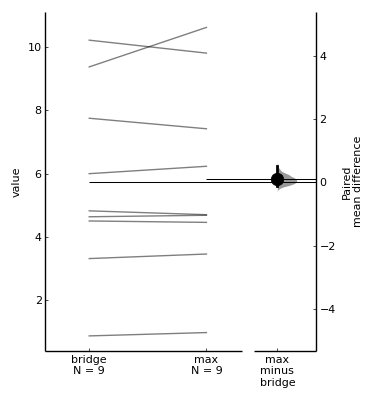

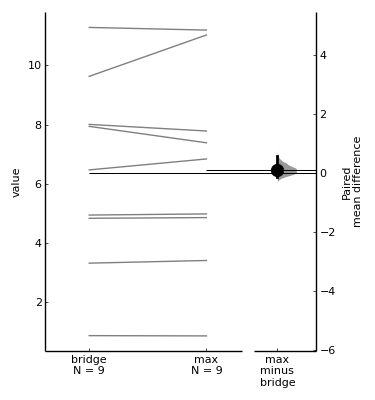

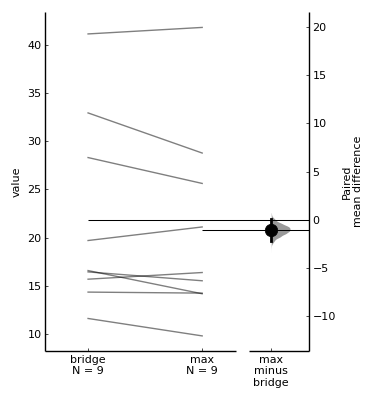

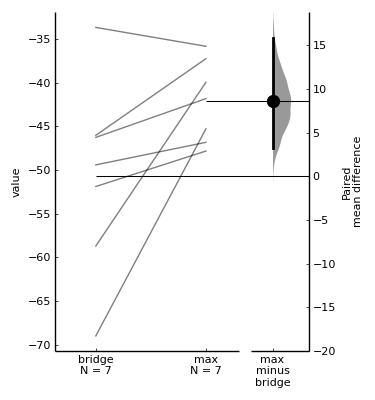

In [15]:
df_max_dcc = summary.loc[summary.groupby(['cell'])['DCCfreq'].idxmax()]
df_bridge = summary.loc[summary['DCCfreq']==0].groupby('cell').mean().reset_index()

df_max_dcc['DCCfreq'] = 'max'
df_bridge['DCCfreq'] = 'bridge'

df = pd.concat([df_max_dcc,df_bridge], axis=0)

props = ['Ion','Ioff','ascSlope','Vthr']
temp = df.pivot(index='cell',columns=['DCCfreq'],values=props)

for prop in props:
    db = dabest.load(data=temp[prop].dropna().reset_index(), 
                     idx=("bridge", "max"), paired=True, id_col='cell')
    print('>>>>>',prop,'<<<<<<<')
    print(db.mean_diff)
    db.mean_diff.plot()

## Numerical simulations

Numerical simulations are performed using the `Brian` simulator (v. 2.4).

In [16]:
import brian2 as br
from brian2.units import *
from tqdm.notebook import tqdm
from tqdm.contrib.itertools import product as tqdm_product

In [17]:
def chop_current(current, dt, freq=1*kHz, duty_cycle=1/3):
    # pad the current array to have a whole number of switching periods
    N_dcc = int(1 / freq / dt)  # number of point in a DCC period
    N = int(np.ceil(current.size / N_dcc))  # number of DCC periods (rounded up)
    # copy, scale, and pad `current` in `chopped current`
    chopped_current = np.zeros(N * N_dcc)
    chopped_current[:current.size] = current / duty_cycle
    # this bit of code reshape the array so that all the DCC periods are aligned
    chopped_current = chopped_current.reshape((N, N_dcc))
    # then replaces the second part of the `duty_cycle` by zeros
    chopped_current[:, int(duty_cycle / freq / dt):] = 0
    # finally re-linearize the array and trim to the initial length
    chopped_current = chopped_current.ravel()[:current.size]
    return chopped_current

In [18]:
def create_ramp(dt, ramp_rate, ramp_max, downward=True):
    # current waveform
    N = int(ramp_max/ramp_rate/dt)
    N *= 2 if downward else 1
    I_ramp = np.full(shape=N,fill_value=ramp_rate*dt)
    if downward:
        I_ramp[int(N/2):] *= -1
    I_ramp = np.cumsum(I_ramp)
    return I_ramp

In [19]:
class brian_tqdm(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
    def update_to(self, time, current_progress, start, end):
        """
        time  : float [seconds]
            amount of time elapsed (in seconds)
        current_progress  : float
            fraction complete from 0 to 1
        start : float [seconds]
            the start time of the simulation
        end : float [seconds]
            the duration of the simulation
        """
        return self.update(current_progress - self.n)

### Electrode + Cell

Both the cell and the electrodes are modeled as passive RC circuits with equations:

$
C * \frac{dV}{dt} = G * (V_0-V) + I_{inj}
$
where
$
C = G * \tau
$

For the cell, the parameters where chosen as $G = G_{in} = 0.2 \mu S$, $\tau_M = 5 ms$

For the electrode, the same equation is used, but $G = 1 \mu S$ and $\tau_e = \tau_M / 200$

If the Bridge were perfectly balanced, the amplifier would record the true voltage of the cell ($V_{bridge} = V_m$).
In DCC mode, the continuous output of the amplifier ($V_{cont.}$) is the sum of $V_{cell}$ and $V_e$, where $V_{cell}$ is the response of the cell to the short pulses of current injected during the DCC. The output of the amplifier ($V_m$) is the output of a sample-and-hold circuit that measures the value of $V_{cont.}$ at the end of the DCC cycle and holds it constant until the next measure.

In [20]:
eqs = '''
dvm/dt = (G_in*(V_r-vm)+I)/(G_in*tau_M) : volt
dve/dt = (G_e*(-ve)+I)/(G_e*tau_e) : volt
I = I_com(t) : amp
'''

In [21]:
br.start_scope()

tau_M = 5*ms
R_in = 5*Mohm
G_in = 1/R_in
V_r = 0*mV
I_inj = 1

G_e = 1*uS
tau_e = tau_M/200

# DCC
DCC_freqs = [0, 1, 5, 15]*kHz
DCC_names = ['Bridge', '1 kHz', '5 kHz', '15 kHz']
D = 1/3

points_per_DCC_period = 10
dt = D / max(DCC_freqs) / points_per_DCC_period
sim_dur = 100 * ms

I_bridge = np.full(int(sim_dur/dt), fill_value=I_inj)

br.defaultclock.dt = dt
G = br.NeuronGroup(1, eqs, method='exact')
M = br.StateMonitor(G, variables=['vm','ve'], record=0)
br.store()

In [22]:
out = {}
for DCC_freq,DCC_name in zip(tqdm(DCC_freqs),DCC_names):
    br.restore()
    if DCC_freq>0:
        I_dcc = chop_current(I_bridge, dt=dt, freq=DCC_freq, duty_cycle=D)
        I_com = br.TimedArray(I_dcc*nA, dt=dt)
    else:
        I_com = br.TimedArray(I_bridge*nA, dt=dt)
    with brian_tqdm(total=1., leave=False) as pbar:
        br.run(sim_dur, report=pbar.update_to, report_period=1*second)
        df = pd.DataFrame({'I':I_com.values/nA, 
                           'Vm':M.vm[0]/mV,
                           'Ve':M.ve[0]/mV},
                          index=M.t/ms)
        out[DCC_name] = df
result_elect_cell = pd.concat(out, axis=1)

In [23]:
result_elect_cell

Bridge                     1 kHz                         5 kHz  \
               I        Vm        Ve     I        Vm            Ve     I   
0.000000     1.0  0.000000  0.000000   3.0  0.000000  0.000000e+00   3.0   
0.002222     1.0  0.002222  0.085053   3.0  0.006665  2.551583e-01   3.0   
0.004444     1.0  0.004442  0.162872   3.0  0.013327  4.886147e-01   3.0   
0.006667     1.0  0.006662  0.234072   3.0  0.019987  7.022150e-01   3.0   
0.008889     1.0  0.008881  0.299216   3.0  0.026643  8.976480e-01   3.0   
...          ...       ...       ...   ...       ...           ...   ...   
99.988889    1.0  5.000000  1.000000   0.0  4.681004  1.227310e-11   0.0   
99.991111    1.0  5.000000  1.000000   0.0  4.678924  1.122924e-11   0.0   
99.993333    1.0  5.000000  1.000000   0.0  4.676845  1.027416e-11   0.0   
99.995556    1.0  5.000000  1.000000   0.0  4.674766  9.400312e-12   0.0   
99.997778    1.0  5.000000  1.000000   0.0  4.672689  8.600790e-12   0.0   

                              15 kHz                      
                 Vm        Ve      I        Vm        Ve  
0.000000   0.000000  0.000000    3.0  0.000000  0.000000  
0.002222   0.006665  0.255158    3.0  0.006665  0.255158  
0.004444   0.013327  0.488615    3.0  0.013327  0.488615  
0.006667   0.019987  0.702215    3.0  0.019987  0.702215  
0.008889   0.026643  0.897648    3.0  0.026643  0.897648  
...             ...       ...    ...       ...       ...  
99.988889  4.778579  0.019105    0.0  4.988868  0.500461  
99.991111  4.776456  0.017480    0.0  4.986652  0.457896  
99.993333  4.774334  0.015993    0.0  4.984436  0.418950  
99.995556  4.772212  0.014633    0.0  4.982221  0.383317  
99.997778  4.770092  0.013388    0.0  4.980007  0.350715  

[45000 rows x 12 columns]

### Apparent conductance of the cell

In [24]:
GIN_FILE_NAME = 'simultations_Gin.csv'

In [25]:
br.start_scope()

# Neuron parameters
tau_Ms = [2,3,4,5] * ms
R_in = 2.5 * Mohm
G_in = 1 / R_in
I_inj = 1
V_r = 0 * mV
I_com = 1 * nA
V_thresh = 20 * mV

# Electrode parameters
R_es = [5,10] * Mohm
G_es = 1 / R_es
reltau_es = [200,300,400]

# DCC parameters
DCC_freqs = [1,2,3,4,5,6,7,8,9,10,15,20]*kHz
D = 1 / 3

# simulation parameters
points_per_DCC_period = 10
dt = D / max(DCC_freqs) / points_per_DCC_period
sim_dur = 50 * ms

I_bridge = np.full(int(sim_dur/dt), fill_value=I_inj)

br.defaultclock.dt = dt
G = br.NeuronGroup(1, eqs, method='exact')
M = br.StateMonitor(G, ['vm','ve'], record=[0])
br.store()

In [26]:
def calc_Gin(row, **kwargs):
    data = row['data']
    data['Vt'] = data['Vm']+data['Ve']
    I = data['I'].mean()
    V = data.loc[data['I'].diff()>0,'Vt'].iloc[-1]
    return pd.Series(I/V, name='Gin')

These simulations take a lot of time to run, the output is cached in a file that can be read directly to avoid running it all again

In [27]:
if not exists(GIN_FILE_NAME):
    out = []
    for DCC_freq,tau_M,G_e,reltau_e in tqdm_product(
        DCC_freqs, tau_Ms, G_es, reltau_es):
        br.restore()
        tau_e = tau_M/reltau_e
        if DCC_freq>0:
            I_dcc = chop_current(I_bridge, dt=dt, freq=DCC_freq, duty_cycle=D)
            I_com = br.TimedArray(I_dcc*nA, dt=dt)
        else:
            I_com = br.TimedArray(I_bridge*nA, dt=dt)
        with brian_tqdm(total=1., leave=False) as pbar:
            br.run(sim_dur, report=pbar.update_to, report_period=1*second)
            df = pd.DataFrame({'I':I_com.values/nA, 
                               'Vm':M.vm[0]/mV,
                               'Ve':M.ve[0]/mV},
                              index=M.t/ms)
            o = {'DCC_freq':DCC_freq/kHz,
                 'tau_M':tau_M/msecond,
                 'G_e':G_e/uS,
                 'tau_e':tau_e/msecond,
                 'data':df}
            out.append(o)
    result_Gin = pd.DataFrame(out)
    result_Gin['Gin'] = result_Gin.apply(calc_Gin, axis=1, result_type='expand')
    result_Gin.drop(columns=['data'], inplace=True)
    result_Gin.to_csv('simultations_Gin.csv',index=False)
else:
    result_Gin = pd.read_csv(GIN_FILE_NAME)

In [28]:
result_Gin['relDCCfreq'] = result_Gin['DCC_freq']*result_Gin['tau_M']
result_Gin['relTau_e'] = (result_Gin['tau_M']/result_Gin['tau_e']).round()
result_Gin['relGin'] = result_Gin['Gin']/(G_in/uS)
result_Gin['R_e'] = 1/result_Gin['G_e']
result_Gin['Rin'] = 1/result_Gin['Gin']
result_Gin['relRin'] = 1/result_Gin['relGin']

In [29]:
result_Gin

,DCC_freq,tau_M,G_e,tau_e,Gin,relDCCfreq,relTau_e,relGin,R_e,Rin,relRin
0,1.0,2.0,0.2,0.010000,0.476930,2.0,200.0,1.192324,5.0,2.096745,0.838698
1,1.0,2.0,0.2,0.006667,0.476930,2.0,300.0,1.192324,5.0,2.096745,0.838698
2,1.0,2.0,0.2,0.005000,0.476930,2.0,400.0,1.192324,5.0,2.096745,0.838698
3,1.0,2.0,0.1,0.010000,0.476930,2.0,200.0,1.192324,10.0,2.096745,0.838698
4,1.0,2.0,0.1,0.006667,0.476930,2.0,300.0,1.192324,10.0,2.096745,0.838698
...,...,...,...,...,...,...,...,...,...,...,...
283,20.0,5.0,0.2,0.016667,0.260280,100.0,300.0,0.650700,5.0,3.842016,1.536806
284,20.0,5.0,0.2,0.012500,0.305493,100.0,400.0,0.763733,5.0,3.273394,1.309358
285,20.0,5.0,0.1,0.025000,0.144058,100.0,200.0,0.360144,10.0,6.941670,2.776668
286,20.0,5.0,0.1,0.016667,0.192586,100.0,300.0,0.481466,10.0,5.192474,2.076990


In [30]:
sns.set()

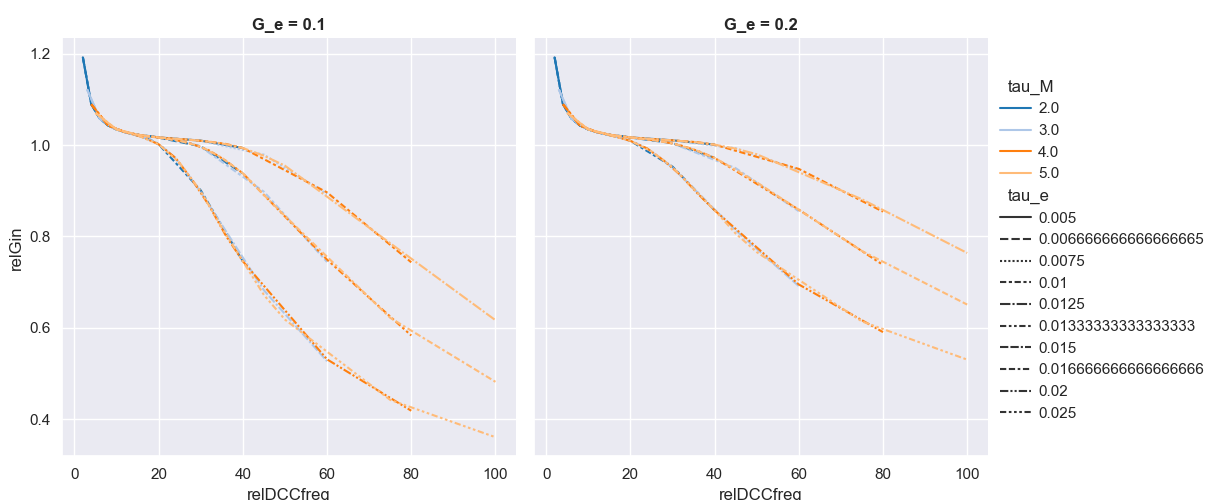

In [31]:
g = sns.relplot(kind='line', data=result_Gin, x='relDCCfreq', y='relGin', col='G_e', 
                hue='tau_M', palette='tab20',
                style='tau_e')

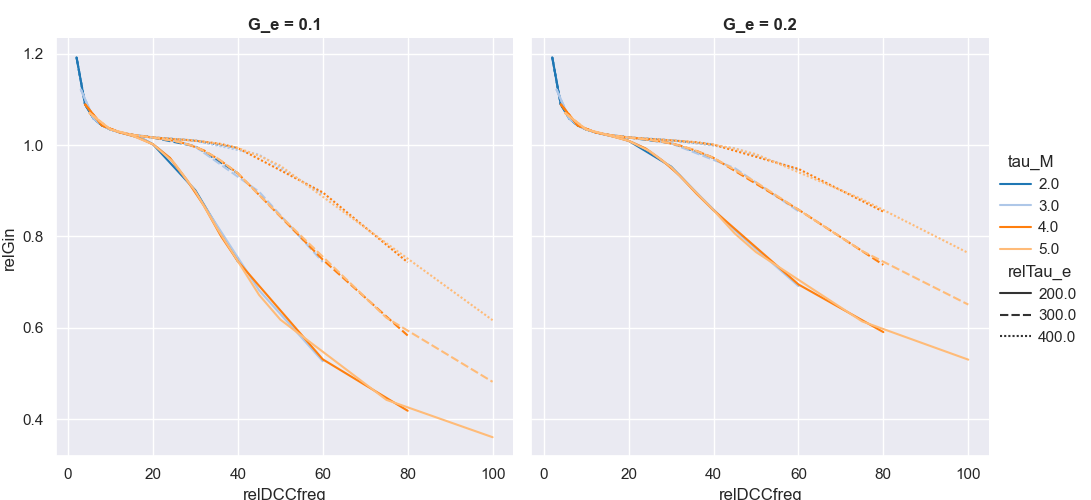

In [32]:
g = sns.relplot(kind='line', data=result_Gin, 
                x='relDCCfreq', y='relGin', col='G_e', 
                hue='tau_M', palette='tab20',
                style='relTau_e')

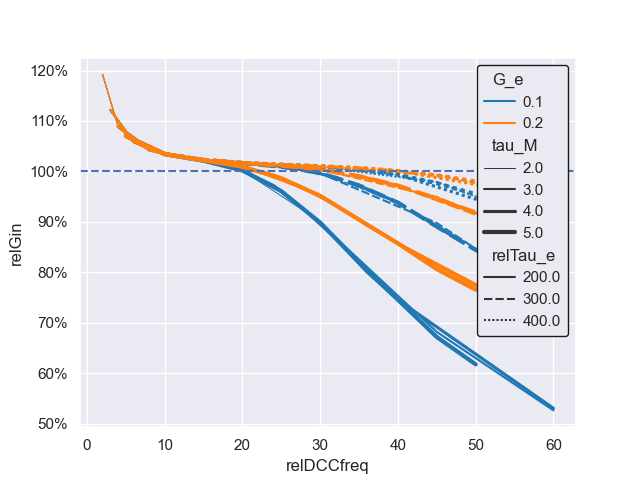

In [33]:
ax = sns.lineplot(data=result_Gin.loc[(result_Gin['relDCCfreq']<=60)], 
                  x='relDCCfreq', y='relGin', 
                  size='tau_M', palette='tab10',
                  style='relTau_e',
                  hue='G_e', estimator=None)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
ax.axhline(1, ls='--')

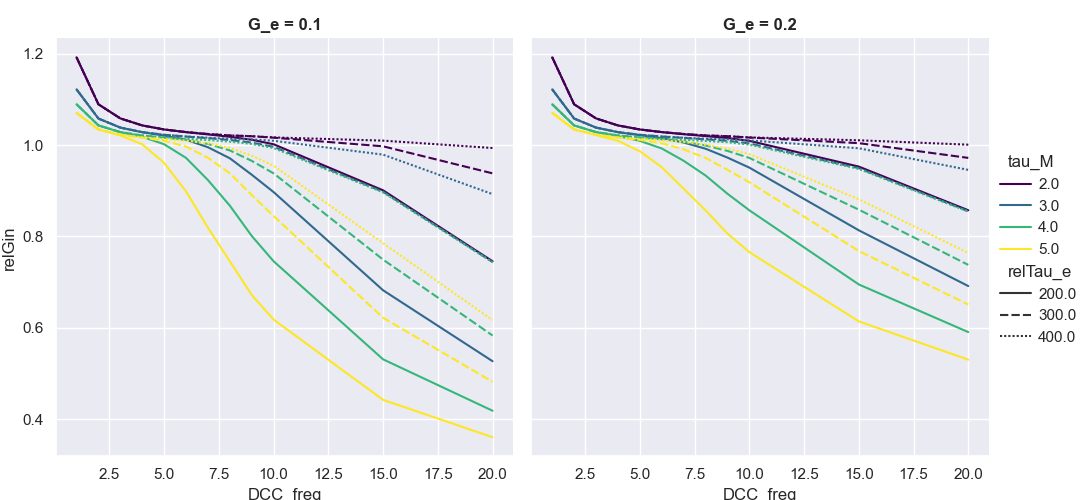

In [34]:
g = sns.relplot(data=result_Gin, x='DCC_freq', y='relGin', col='G_e', 
                hue='tau_M', palette='viridis',
                style='relTau_e',
                kind='line')

#### Figure-Gin-DCC-sim

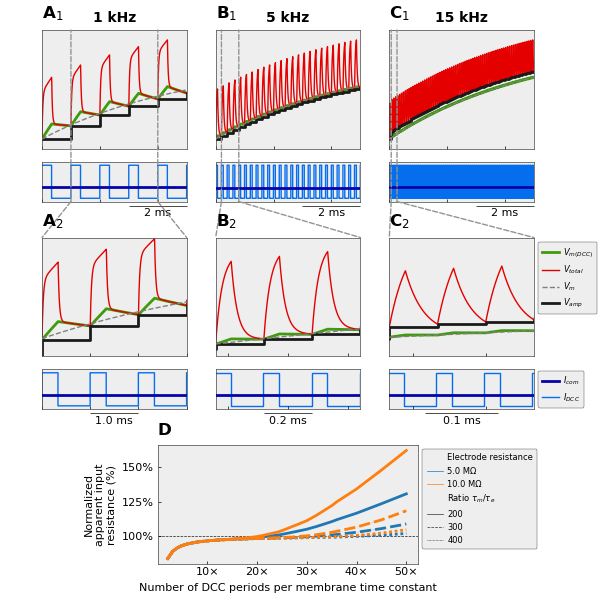

In [35]:
from matplotlib.patches import ConnectionPatch
N=3
cols = ['1 kHz', '5 kHz', '15 kHz']
freqs = [1e3, 5e3, 15e3]
ylims = [(0,6),(-0.25,4),(-0.5,3)]
dt0 = D / max(freqs)*Hz / points_per_DCC_period

ripples_Rin = 2.5
ripples_tauM = 3
ripples_Icom = 10


sns.set()
plt.style.use('default')
with plt.style.context(['default','MM-paper','MM-model',{'axes.ymargin':0.1, 'axes.xmargin':0.0}]):
    fig, axs = plt.subplots(7,3, figsize=(6,6), constrained_layout=False,
                           gridspec_kw=dict(height_ratios=[3,1,0.25,3,1,0.25,3]))
    
    gs0 = axs.flatten()[0].get_gridspec()

    
    for i,(col,tbar,xmin,freq,ylim) in enumerate(zip(cols,[1,0.2,0.1],[0,0,0],freqs,ylims)):
        xmax = xmin+5
        
        axV = axs[0,i]
        axI = axs[1,i]

        mask = (result_elect_cell.index>=xmin)&(result_elect_cell.index<xmax)
        df = result_elect_cell.loc[mask, col]
        
        for axV,axI in zip([axs[0,i],axs[3,i]], [axs[1,i], axs[4,i]]):
            axV.set_yticklabels([]); axV.set_xticklabels([])
            axI.set_yticklabels([]); axI.set_xticklabels([])
            axI.axhline(df['I'].mean(), c='xkcd:royal blue',    zorder=10, label='$I_{com}$', lw=2)
            axI.step(df.index, df['I'], c='xkcd:cerulean blue', zorder=1, label='$I_{DCC}$', lw=1)

            axV.plot(df.index, df['Vm'],          c='xkcd:grass green', lw=2, label='$V_{m(DCC)}$')
            axV.plot(df.index, df['Vm']+df['Ve'], c='xkcd:red',         lw=1, label='$V_{total}$')
            axV.plot(result_elect_cell.loc[mask].index, result_elect_cell.loc[mask, ('Bridge','Vm')], c='grey', ls='--', zorder=10, lw=1, label='$V_{m}$')
            # samples are taken at the end of each DCC cycle
            df_dcc = result_elect_cell.iloc[::int(1/freq / dt0)]
            df_dcc = df_dcc.loc[(df_dcc.index>=xmin)&(df_dcc.index<xmax), col]
            axV.step(df_dcc.index, df_dcc['Vm']+df_dcc['Ve'], where='post', lw=2, label='$V_{amp}$', c='k')
            axV.set_yticks([])
            axI.set_yticks([])
        
        for ax in axs[3:5,i].flat:
            ax.set_xlim(xmin+1e3/freq, xmin+1e3*(N+1)/freq)
            ax.set_yticks([])
        axs[3,i].set_ylim(ylim)
        
        ax = axs[1,i]
        t = HSizeBar(ax.transData, 2, '2 ms', loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
        ax.add_artist(t)
        
        ax = axs[4,i]
        t = HSizeBar(ax.transData, tbar, f'{tbar:.1f} ms', loc='upper center',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(0.5, -0.1),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
        ax.add_artist(t)
        
        conn_kwargs=dict(color='xkcd:grey', lw=1, ls='--', zorder=100)
        transform = matplotlib.transforms.blended_transform_factory(axs[1,i].transData, axs[1,i].transAxes)
        for x0,x1 in enumerate([xmin+1e3/freq,xmin+1e3*(N+1)/freq]):
            con = ConnectionPatch(xyA=(x1,0), coordsA=transform, axesA=axs[1,i],
                            xyB=(x0,1), coordsB='axes fraction', axesB=axs[3,i],
                            **conn_kwargs)
            axs[3,i].add_artist(con)
        
            con = ConnectionPatch(xyA=(x1,0), coordsA=axs[1,i].get_xaxis_transform(), axesA=axs[1,i],
                                  xyB=(x1,1), coordsB=axs[0,i].get_xaxis_transform(), axesB=axs[0,i],
                                  **conn_kwargs)
            axs[1,i].add_artist(con)

    axs[3,-1].legend(loc='upper left', bbox_to_anchor=(1,1))
    axs[4,-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    
    for i in range(3):
        axs[2,i].remove()
        axs[5,i].remove()
        axs[6,i].remove()
        
    with plt.style.context(['default','MM-paper','MM-model',{'axes.ymargin':0.05, 'axes.xmargin':0.05}]):
        gs01 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs0[6,:],
                                                           width_ratios=[1,3,1])
        ax1 = fig.add_subplot(gs01[1])
    
    # apparent conductance vs. DCC freq
    df = result_Gin.loc[result_Gin['relDCCfreq']<60]
    sns.lineplot(ax=ax1, data=df,
                x='relDCCfreq', y='relRin', 
                hue='R_e', palette='tab10',
                style='relTau_e', legend=True, lw=2)
    ax1.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
    ax1.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, symbol='×', decimals=0))
    ax1.set_ylabel('Normalized\napparent input\nresistance (%)')
    ax1.set_xlabel('Number of DCC periods per membrane time constant')
    # pretty up the legend created by seaborn
    h,l = ax1.get_legend_handles_labels()
    l[0] = 'Electrode resistance'
    m = [k for k,_ in df.groupby('R_e')]
    for i,n in enumerate(m):
        l[i+1] = f'{n:.1f} MΩ'
    j = i+2
    l[j] = 'Ratio $\\tau_m$/$\\tau_e$'
    m = [k for k,_ in df.groupby('relTau_e')]
    for i,n in enumerate(m):
        l[i+j+1] = f'{n:.0f}'
    ax1.legend(h,l, bbox_to_anchor=(1,1))
    ax1.axhline(1, ls='--', color='k', zorder=0)
    ax1.set_xlim(left=0.0001)
    
    
    
    
    
    with plt.style.context(['default','MM-paper']):
        for ax,l,col in zip(axs[0,:],['A$_1$','B$_1$','C$_1$'],cols):
            ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                          xytext=(0,5), textcoords='offset points',
                          ha='left', va='bottom', fontsize=12, fontweight='bold')
            ax.set_title(col)
        for ax,l in zip(axs[3,:],['A$_2$','B$_2$','C$_2$']):
            ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                          xytext=(0,5), textcoords='offset points',
                          ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)
        ax1.annotate('D',xy=(0,1),xycoords='axes fraction',
                         xytext=(0,5), textcoords='offset points',
                         ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)

        
    
        
        
        
        
#fig.set_facecolor('grey')
fig.subplots_adjust(left=0.07, right=0.89, top=0.95, bottom=0.06)
plt.show()

#### Figure-Gin-DCC

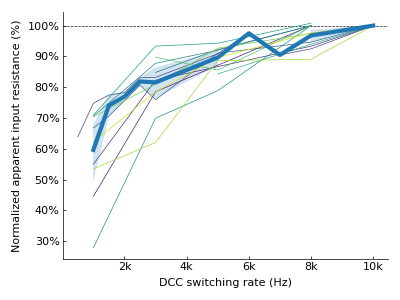

In [36]:
plt.style.use(['default','MM-paper',{'axes.ymargin':0.05, 'axes.xmargin':0.05}])
fig, ax = plt.subplots(figsize=(4,3), dpi=100)
sns.lineplot(data=summary_norm, x='DCCfreq', y='Rin', hue='cell', ci=None, ax=ax, legend=False, palette='viridis')
sns.lineplot(data=summary_norm.loc[summary_norm['DCCfreq']>=1000], x='DCCfreq', y='Rin', 
             ax=ax, legend=False, lw=3, color='C0',
             ci=95, zorder=10)
ax.axhline(1, ls='--', color='k', zorder=0)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100000, decimals=0, symbol='k'))
ax.set_ylabel('Normalized apparent input resistance (%)')
ax.set_xlabel('DCC switching rate (Hz)')
ax.annotate('',xy=(0,1),xycoords='axes fraction',
                 xytext=(0,5), textcoords='offset points',
                 ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)

fig.tight_layout()
plt.show()

### Amplitude of the ripples

In [37]:
RIPPLES_FILE_NAME = 'result_ripples.pickle'

In [38]:
br.start_scope()

# Neuron parameters
tau_Ms = [2,3,4,5] * ms
R_ins = [1.5,2.5,5] * Mohm
G_ins = 1 / R_ins
I_injs = [1,5,10]
V_r = 0 * mV
I_com = 1 * nA
V_thresh = 20 * mV

# DCC parameters
DCC_freqs = np.arange(1,16,1) * kHz
D = 1 / 3

# simulation parameters
points_per_DCC_period = 10
dt = D / max(DCC_freqs) / points_per_DCC_period
sim_dur = 50 * ms

meas_window = 10*ms

br.defaultclock.dt = dt
G = br.NeuronGroup(1, eqs, method='exact')
M = br.StateMonitor(G, ['vm'], record=[0])
br.store()

These simulations take a lot of time to run, the output is cached in a file that can be read directly to avoid running it all again

In [39]:
if not exists(RIPPLES_FILE_NAME):
    out = []
    for DCC_freq, G_in, tau_M, I_inj in tqdm_product(DCC_freqs, G_ins, tau_Ms, I_injs):
        br.restore()
        I_bridge = np.full(shape=int(sim_dur / dt), fill_value=I_inj)
        I_dcc = chop_current(I_bridge, dt, freq=DCC_freq, duty_cycle=D)
        I_com = br.TimedArray(I_dcc*nA, dt=dt)
        with brian_tqdm(total=1., leave=False) as pbar:
            br.run(sim_dur, report=pbar.update_to, report_period=1*second)
        ripple_amp = np.ptp(M.vm[0,-int(meas_window/dt):])
        o = {'DCC_freq':DCC_freq/kHz,
             'I_com':I_inj, 
             'R_in':1/G_in / Mohm, 
             'tau_M':tau_M / ms, 
             'data':M.vm[0], 
             'ripple_amp': ripple_amp}
        out.append(o)
    with open(RIPPLES_FILE_NAME, 'wb') as f:
        pickle.dump(out, f)    
else:
    with open(RIPPLES_FILE_NAME, 'rb') as f:
        out = pickle.load(f)

result_ripples = pd.DataFrame(out)

In [40]:
result_ripples['relDCCfreq'] = result_ripples['tau_M'] * result_ripples['DCC_freq']
result_ripples['ripple_amp_AU'] = result_ripples['ripple_amp'].apply(lambda x: x/mV)

In [41]:
result_ripples

,DCC_freq,I_com,R_in,tau_M,data,ripple_amp,relDCCfreq,ripple_amp_AU
0,1.0,1,1.5,2.0,"[0. V, 4.99722325 uV, 9.98889711 uV, 14.975027...",0.49769903 mV,2.0,0.497699
1,1.0,5,1.5,2.0,"[0. V, 24.98611625 uV, 49.94448557 uV, 74.8751...",2.48849516 mV,2.0,2.488495
2,1.0,10,1.5,2.0,"[0. V, 49.97223251 uV, 99.88897115 uV, 149.750...",4.97699033 mV,2.0,4.976990
3,1.0,1,1.5,3.0,"[0. V, 3.33209907 uV, 6.66173083 uV, 9.9888971...",0.33265136 mV,3.0,0.332651
4,1.0,5,1.5,3.0,"[0. V, 16.66049535 uV, 33.30865416 uV, 49.9444...",1.6632568 mV,3.0,1.663257
...,...,...,...,...,...,...,...,...
535,15.0,5,5.0,4.0,"[0. V, 41.65509474 uV, 83.28705418 uV, 124.895...",278.81136306 uV,60.0,0.278811
536,15.0,10,5.0,4.0,"[0. V, 83.31018947 uV, 166.57410836 uV, 249.79...",0.55762273 mV,60.0,0.557623
537,15.0,1,5.0,5.0,"[0. V, 6.6651854 uV, 13.32740916 uV, 19.986672...",45.88615281 uV,75.0,0.045886
538,15.0,5,5.0,5.0,"[0. V, 33.32592702 uV, 66.63704581 uV, 99.9333...",229.43076403 uV,75.0,0.229431


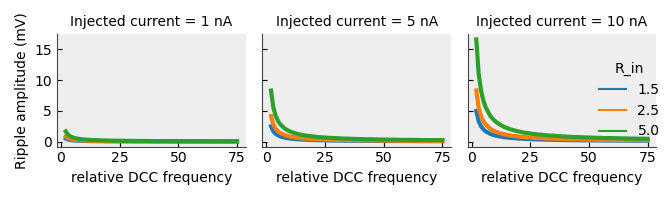

In [42]:
plt.style.use(['default','MM-model'])
g = sns.relplot(kind='line', data=result_ripples, x='relDCCfreq', y='ripple_amp_AU', hue='R_in', 
                col='I_com', palette='tab10', lw=3, height=2)
g.set_axis_labels(x_var='relative DCC frequency', y_var='Ripple amplitude (mV)')
g.set_titles(col_template="Injected current = {col_name} nA")
plt.tight_layout()

#### Figure-ripples

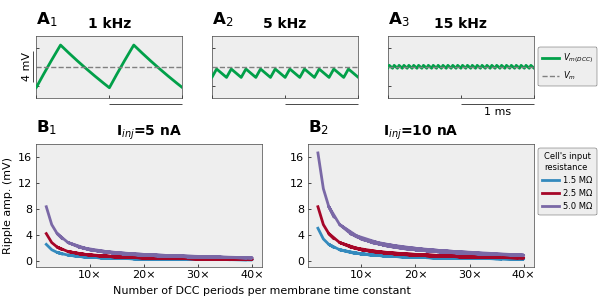

In [43]:
sns.set()
plt.style.use(['default','MM-paper','MM-model',{'axes.ymargin':0.1, 'axes.xmargin':0.0}])


cols = ['1 kHz', '5 kHz', '15 kHz']
freqs = [1e3, 5e3, 15e3]
ylims = [(0,6),(-0.25,4),(-0.5,3)]
dt0 = D / max(freqs)*Hz / points_per_DCC_period

ripples_Rin = 2.5
ripples_tauM = 3
ripples_Icom = 10


fig = plt.figure(figsize=(6,3), dpi=100)

gs0 = matplotlib.gridspec.GridSpec(2,3, height_ratios=[1,2], hspace=0.5)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1,:])

axs0 = [None]*3
axs0 = [fig.add_subplot(gs0[0,i], sharey=axs0[0]) for i in range(3)]

axs1 = [None]*2
axs1 = [fig.add_subplot(gs1[0,i], sharey=axs1[0]) for i in range(2)]


sim_dur = 50*ms
t_ = np.linspace(0,sim_dur,int(sim_dur/dt))
temp = result_ripples.loc[(result_ripples['I_com']==ripples_Icom)&
                          (result_ripples['R_in']==ripples_Rin)&
                          (result_ripples['tau_M']==ripples_tauM)]
for i,(freq,ax) in enumerate(zip(freqs, axs0)):
    y = temp.loc[temp['DCC_freq']==freq/1000,'data'].iloc[0]/mV
    ax.plot(t_,y, lw=2, c=VmColor, label='$V_{m(DCC)}$', zorder=9)
    ax.axhline(10*2.5, color='grey', ls='--', zorder=10, lw=1, label='$V_{m}$')
    ax.set_xlim(0.04,0.042)
    ax.set_ylim(21,29)
    #ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.set_title(f'{freq:d} kHz')
ax = axs0[0]
v = VSizeBar(ax.transData, 4, '4 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(v)
for ax,l in zip(axs0, ['','','1 ms']):
    t = HSizeBar(ax.transData, 1e-3, l, loc='upper right',
                     pad=0, borderpad=0, sep=2,
                     frameon=False,
                     bbox_to_anchor=(1, -0.1),
                     bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
    ax.add_artist(t)
axs0[-1].legend(loc='center left', bbox_to_anchor=(1,0.5))

Is = [5,10]
Rs = [1.5,2.5,5]

for ax,I in zip(axs1, Is):
    ax.margins(x=0.05)
    for R in Rs:
        df = result_ripples.loc[(result_ripples['I_com']==I)&
                                (result_ripples['R_in']==R)&
                                (result_ripples['relDCCfreq']<=40)]
        ax.plot(df['relDCCfreq'],df['ripple_amp_AU'], lw=2, label=f'{R:.1f} MΩ')
    ax.set_title(f'I$_{{inj}}$={I:.0f} nA')
for ax in axs1:
    ax.set_ylim(-1,18)
    ax.set_xticks([10,20,30,40])
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(symbol='×', decimals=0))
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=4, nbins=5))
axs1[0].set_ylabel('Ripple amp. (mV)')
l = axs1[0].set_xlabel('Number of DCC periods per membrane time constant', ha='center', x=1)
axs1[-1].legend(loc='upper left', bbox_to_anchor=(1,1), title='Cell\'s input\nresistance')


with plt.style.context(['default','MM-paper']):
    for ax,l,col in zip(axs0,['A$_1$','A$_2$','A$_3$'],cols):
        ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                      xytext=(0,5), textcoords='offset points',
                      ha='left', va='bottom', fontsize=12, fontweight='bold')
        ax.set_title(col)
    for ax,l in zip(axs1,['B$_1$','B$_2$']):
        ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                      xytext=(0,5), textcoords='offset points',
                      ha='left', va='bottom', fontsize=12, fontweight='bold')

#fig.set_facecolor('grey')
fig.subplots_adjust(left=0.06, right=0.89, top=None, bottom=None)
plt.show()

### Staircase effect

For the firing model, we use the same equations as in (Meunier and Borejsza, 2005) and (Manuel et al., 2006):

$$
\begin{align}
C*\frac{dV_m}{dt} & = G_{in}*(V_r-V_m)+I_{AHP}+I_{inj}+\sigma\xi \\
I_{AHP} & = \bar{g}_{AHP} * z * (E_k-V_m) \\
\frac{dz}{dt} & = \frac{-z}{\tau_{AHP}} \\
\end{align}
$$
    
    

for simplicity, the dynamic of the AHP during the spike is not modeled, and instead, the parameter $z$ is incremented instantenously at each spike according to:
$$ z_{after} = (1 - \alpha) * z_{before} + \alpha $$

In [44]:
eqs = '''
dv/dt = (G_in*(V_r-v)+I_ahp+I)/(G_in*tau_M) + sigma*xi: volt
I = I_com(t) : amp
I_ahp = G_ahp * z * (E_k-v) : amp
dz/dt = -z/tau_ahp : 1
'''
z_eq = 'z = (1-alpha)*z+alpha'

In [45]:
# Neuron parameters
tau_M = 2 * ms
R_in = 1.5 * Mohm
G_in = 1/R_in
V_r = 0 * mV
V_thresh = 10 * mV
refract = 2 * ms
sigma = 0.05 * mV * ms ** -0.5
G_ahp = 2 * uS
E_k = -5 * mV
tau_ahp = 10 * ms
alpha = 0.25
D = 1 / 3
points_per_DCC_period = 10
ramp_rate = 1 * nA / second
ramp_max = 15 * nA

DCC_freqs = [0, 1, 3, 8] * kHz

In [46]:
traces_staircase = pd.DataFrame()
FI_curves_staircase = pd.DataFrame()
for DCC_freq in tqdm(DCC_freqs):
    br.start_scope()
    br.seed(4321)  # for reproductibility
    if DCC_freq == 0:
        dt = 100 * us
    else:
        dt = D / DCC_freq / points_per_DCC_period
    
    br.defaultclock.dt = dt

    I_ramp = create_ramp(dt, ramp_rate, ramp_max, downward=False)
    sim_dur = ramp_max/ramp_rate

    G = br.NeuronGroup(1, eqs, method='euler', threshold='v>V_thresh', refractory=refract)
    S = br.Synapses(G, on_pre=z_eq)
    S.connect()
    M = br.StateMonitor(G, variables=['v', 'z', 'I'], record=[0])
    SM = br.SpikeMonitor(G)

    I_bridge = br.TimedArray(I_ramp * amp, dt=dt)
    if DCC_freq == 0:  # Bridge mode
        I_com = I_bridge
    else:
        I_dcc = chop_current(I_ramp, dt, freq=DCC_freq, duty_cycle=D)
        I_com = br.TimedArray(I_dcc * amp, dt=dt)
    
    with brian_tqdm(total=1., leave=False) as pbar:
        br.run(sim_dur, report=pbar.update_to)
    
    t = pd.DataFrame({'t':M.t/second,'v':M.v[0]/mV, 'z':M.z[0], 'I':M.I[0]/nA}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f = pd.DataFrame({'i':ramp_rate*SM.t/nA,'t':SM.t/second}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f['freq'] = 1./f['t'].diff()
    traces_staircase = pd.concat([traces_staircase, t], axis=0)
    FI_curves_staircase = pd.concat([FI_curves_staircase, f], axis=0)

In [47]:
for f in [1,3,8]*kHz:
    print(D / f / points_per_DCC_period)

33.33333333 us
11.11111111 us
4.16666667 us


Text(0.5, 0, 'ISI normalized by DCC period')

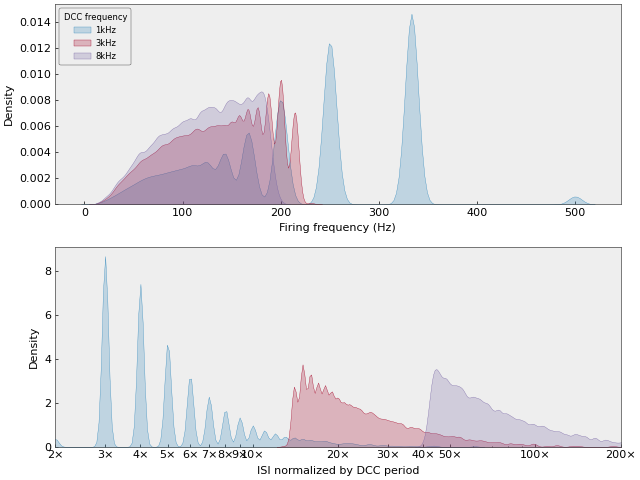

In [48]:
xticks = np.concatenate([np.arange(2,11),[20,30,40,50],[100,200]])
#xticklabels = np.full(shape=xticks.shape, fill_value=None)
#xticklabels[:8] = [f'{a}×' for a in [3,4,5,6,7,8,9,10]]
#xticklabels[17] = '20×'
#xticklabels[20] = '50×'

plt.style.use(['default','MM-paper','MM-model'])
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout=True)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

for f,o in FI_curves_staircase.loc[FI_curves_staircase['DCC_freq']>0].groupby('DCC_freq'):
    freq = o['freq']
    sns.kdeplot(x=freq, fill=True, bw_adjust=0.3, label=f'{f/1000:.0f}kHz', ax=ax1)
    sns.kdeplot(x=(1/freq)/(1/f), fill=True, bw_adjust=0.2, label=f'{f/1000:.0f}kHz', ax=ax2, log_scale=True)

ax2.set_xlim(4,100)    

ax2.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, symbol='×'))
ax2.set_xticks(xticks)
#ax2.set_xticklabels(xticklabels, rotation=90)
#ax2.invert_xaxis()

ax1.legend(title='DCC frequency', loc='upper left')
ax1.set_xlabel('Firing frequency (Hz)')
ax2.set_xlabel('ISI normalized by DCC period')


#### Figure-step-pattern

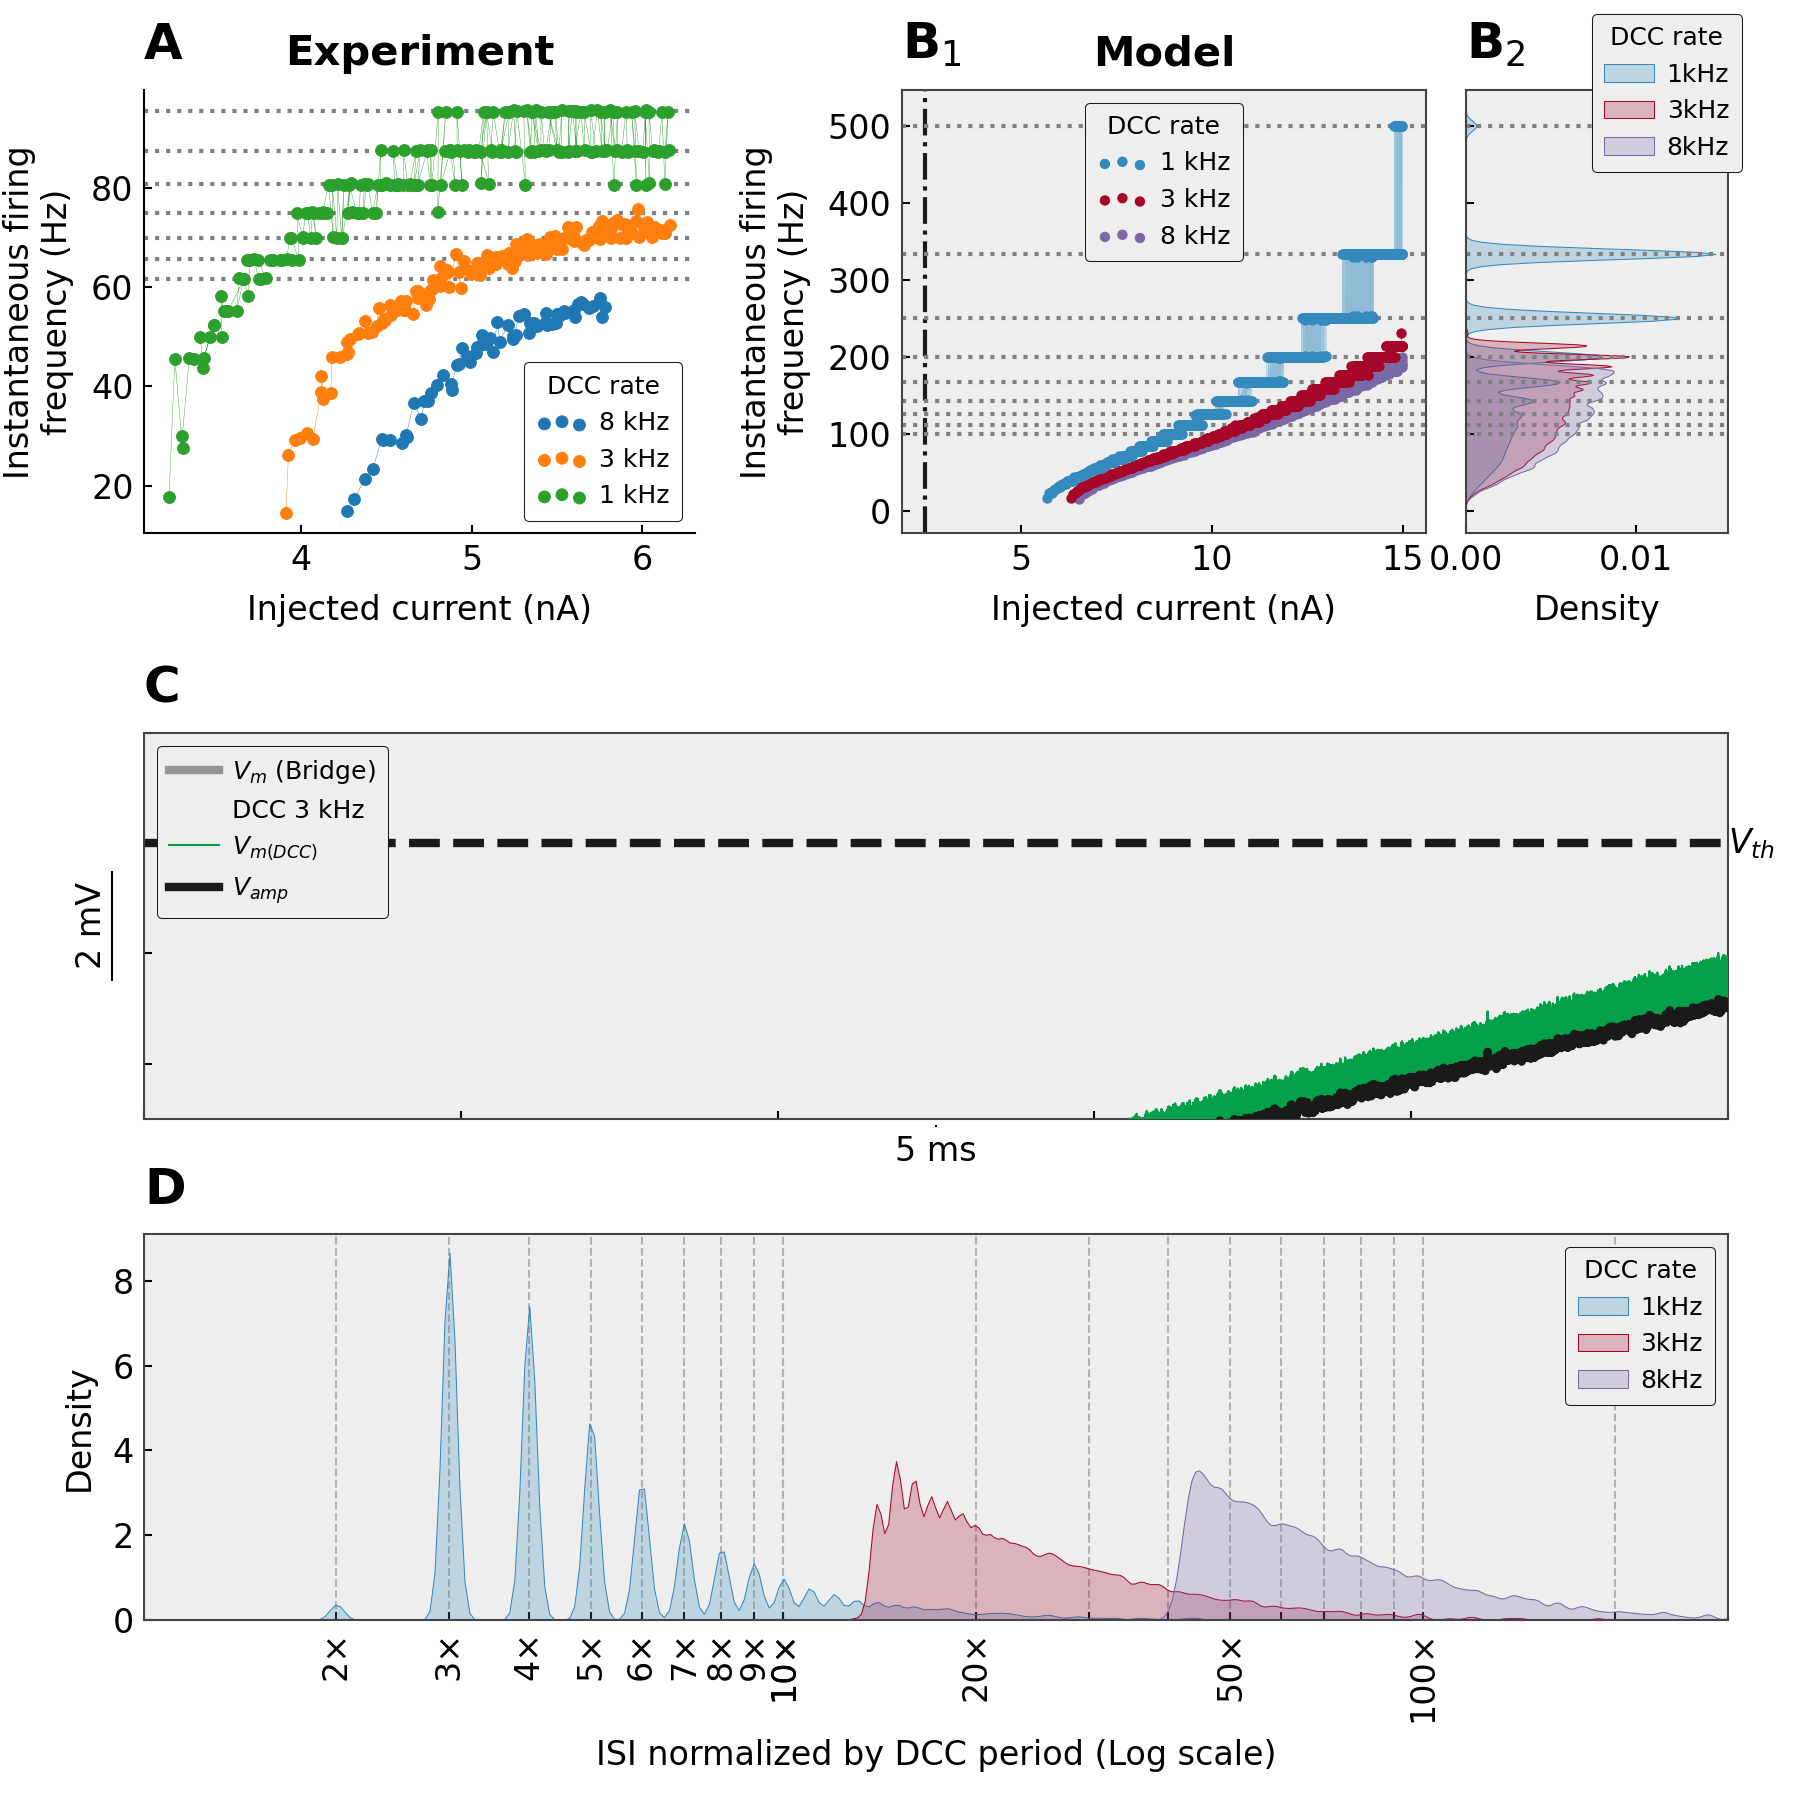

In [49]:
plt.style.use(['default','MM-paper',{'axes.xmargin':0.05, 'axes.ymargin':0.05}])


fig = plt.figure(constrained_layout=False, figsize=(6,6), dpi=300)
gs = matplotlib.gridspec.GridSpec(2,2, figure=fig, 
                                  width_ratios=[1,1.5],
                                  height_ratios=[1,2],
                                  wspace=0.3, hspace=0.3)
gs0 = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,1],
                                                  width_ratios=[1,0.5], wspace=0.1)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,:],
                                                  hspace=0.3)

ax1 = fig.add_subplot(gs[0,0])
ax = ax1
ax.set_title('Experiment')
for file, freq in zip(['20200701_Cell4090_006_IFCurve_DCC8kHz.txt',
                       '20200701_Cell4090_006_IFCurve_DCC3kHz.txt',
                       '20200701_Cell4090_006_IFCurve_DCC1kHz.txt'],
                      ['8 kHz', '3 kHz', '1 kHz']):
    df = pd.read_csv(file, sep='\t', usecols=[2,3], header=0, names=['Im','Freq'])
    ax.scatter(df['Im'],df['Freq'],s=8,label=freq, zorder=10)
    ax.plot(df['Im'],df['Freq'],'-', lw=0.1, zorder=9)


ax.set_xlabel('Injected current (nA)')
ax.set_ylabel('Instantaneous firing\nfrequency (Hz)')
ax.legend(loc='lower right', scatterpoints=3, title='DCC rate')
DCCfreq = 1050
for d in range(11,18,1):
    ax.axhline(DCCfreq/d, ls=':', c='grey', lw=1, zorder=2)
#    ax.annotate(f'1/{d}', xy=(1,DCCfreq/d), xycoords=('axes fraction', 'data'),
#                ha='left', va='center', fontsize=6)


plt.style.use(['default','MM-paper','MM-model'])
ax2 = fig.add_subplot(gs0[0,0])
ax3 = fig.add_subplot(gs0[0,1], sharey=ax2)
zs = [5.3,5.2,5.1]
for z,(f,o) in zip(zs,FI_curves_staircase.loc[FI_curves_staircase['DCC_freq']>0].groupby('DCC_freq')):
    ax2.scatter(o['i'],o['freq'], 
               s=5, label=f'{f/1000:.0f} kHz', zorder=z)
    ax2.plot(o['i'],o['freq'],'-', lw=0.1, zorder=z, alpha=0.5)
    
    sns.kdeplot(y=o['freq'], fill=True, bw_adjust=0.3, label=f'{f/1000:.0f}kHz', ax=ax3)
ax2.set_xlabel('Injected current (nA)')
ax2.set_ylabel('Instantaneous firing\nfrequency (Hz)')
ax2.legend(scatterpoints=3, title='DCC rate')
ax2.set_title('Model')
ax2.axvline(np.mean([xmin,xmax]), ls='-.', color='k', lw=1)

plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.yaxis.get_label(), visible=False)
ax3.legend(loc='upper right', bbox_to_anchor=(1.1,1.2), title='DCC rate')


for ax in [ax2, ax3]:
    DCCfreq = 1000
    for d in range(2,11,1):
        ax.axhline(DCCfreq/d, ls=':', c='grey', lw=1, zorder=2)
    #    ax.annotate(f'1/{d}', xy=(1,DCCfreq/d), xycoords=('axes fraction', 'data'),
    #                ha='left', va='center', fontsize=6)



ax4 = fig.add_subplot(gs1[0])
ax = ax4
ax.set_axisbelow(True)
ymin, ymax = 5,12

# Bridge trace
DCC_freq=0
o = traces_staircase.loc[(traces_staircase['DCC_freq']==DCC_freq)&(traces_staircase['t'].between(xmin,xmax))]
p = FI_curves_staircase.loc[(FI_curves_staircase['DCC_freq']==DCC_freq)&FI_curves_staircase['t'].between(xmin,xmax)]
ax.plot(o['t'], o['v'], c='xkcd:grey', lw=2, ls='-', label='$V_m$ (Bridge)', zorder=2)
ax.eventplot(p['t']+1e-4, lineoffsets=11, linelengths=2, colors='xkcd:grey', linewidths=2, linestyles='-', zorder=2)
t_spikes_bridge = p['t']

# DCC trace
DCC_freq=3000
dt = D / DCC_freq / points_per_DCC_period
o = traces_staircase.loc[(traces_staircase['DCC_freq']==DCC_freq)&(traces_staircase['t'].between(xmin,xmax))]
p = FI_curves_staircase.loc[(FI_curves_staircase['DCC_freq']==DCC_freq)&FI_curves_staircase['t'].between(xmin,xmax)]
a = (traces_staircase.loc[traces_staircase['DCC_freq']==DCC_freq]
     .iloc[::int(points_per_DCC_period/D)]
)
q = a.set_index('t').reindex(traces_staircase.loc[traces_staircase['DCC_freq']==DCC_freq].set_index('t').index).reset_index().ffill()
#q = q.loc[q['t'].between(xmin,xmax)]
v_dcc_spikes = q.set_index('t').loc[p['t'],'v'].values
t_spikes_dcc = p['t']

ax.plot(o['t'], o['v'], c=VmColor, lw=0.5, label=f'$V_{{m(DCC)}}$', zorder=3)
ax.eventplot(p['t'], lineoffsets=11, linelengths=2, colors='C0', linewidths=1, linestyles='--', zorder=3)

ax.plot(q['t'], 
        q['v'],
        color='k', lw=2, ls='-',
        label=f'$V_{{amp}}$', zorder=4)
ax.vlines(p['t'], ymin=v_dcc_spikes, ymax=12, color='k', lw=2, ls='-', zorder=4)

ax.axhline(10, ls='--', lw=2, color='k')
ax.annotate("$V_{th}$", xy=(1,10), xycoords=('axes fraction','data'), 
            ha='left', va='center', fontsize=8)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

pos = 1.05
for t,u in zip(t_spikes_dcc[:-1],t_spikes_dcc[1:]):
    print(t,u)
    ax.annotate('', xy=(t,pos), xytext=(u,pos), xycoords=('data','axes fraction'),
               arrowprops=dict(arrowstyle='<->', lw=2, color='k', shrinkA=0, shrinkB=0))
    ax.annotate(f'{(u-t)*(DCC_freq):.0f}× DCC periods', 
                xy=(t+(u-t)/2,pos), xycoords=('data','axes fraction'),
                xytext=(0,2), textcoords='offset points',
                ha='center', va='bottom', fontsize=8)

for t,u in zip(t_spikes_bridge[1:], t_spikes_dcc[1:]):
    print(t,u)
    ax.annotate('', xy=(t,0.75), xycoords=('data','axes fraction'), xytext=(u,0.75), 
                arrowprops=dict(arrowstyle='<-', lw=2, color='xkcd:grey'))
    
ax.set_yticklabels([])
ax.set_xticklabels([])

v = VSizeBar(ax.transData, 2, '2 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(v)

t = HSizeBar(ax.transData, 5e-3, '5 ms', loc='upper center',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(0.5, -0.02),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(t)

h,l = ax.get_legend_handles_labels()
proxy, = ax.plot([],[],'-',lw=0)
h.insert(1, proxy)
l.insert(1, f'DCC {DCC_freq/1000:.0f} kHz')
ax.legend(h,l, loc='upper left', bbox_to_anchor=(0,1))



ax5 = fig.add_subplot(gs1[1])
ax = ax5
ax.set_axisbelow(True)

for f,o in FI_curves_staircase.loc[FI_curves_staircase['DCC_freq']>0].groupby('DCC_freq'):
    sns.kdeplot(x=f/o['freq'], fill=True, bw_adjust=0.2, log_scale=True, 
                label=f'{f/1000:.0f}kHz', ax=ax)

        
xticks = np.concatenate([np.arange(2,11),np.arange(10,100,10),[100,200]])
xticklabels_pos=[2,3,4,5,6,7,8,9,10,20,50,100]
xticklabels = [f'{a}×' if a in xticklabels_pos else '' for a in xticks]
ax.set_xlim(1,300)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)

ax.set_xlabel('ISI normalized by DCC period (Log scale)')
ax.grid(True, axis='x', which='major', lw=0.5, ls='--')
ax.legend(loc='upper right', title='DCC rate')


for ax,l in zip(fig.axes,
                ['A','B$_1$','B$_2$','C','D']):
    ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                  xytext=(0,5), textcoords='offset points',
                  ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)

#fig.set_facecolor('grey')
fig.subplots_adjust(left=0.08, right=0.96, top=0.95, bottom=0.1)
plt.show()

### Secondary range

In [50]:
# Neuron parameters
R_in = 2.5 * Mohm
G_in = 1/R_in
DCC_freqs = [0, 3] * kHz

In [51]:
FI_curves_secrange = pd.DataFrame()
for DCC_freq in tqdm(DCC_freqs):
    br.start_scope()
    np.random.seed(14235976)  # for reproductibility
    if DCC_freq == 0:
        dt = 100 * us
    else:
        dt = D / DCC_freq / points_per_DCC_period
    
    br.defaultclock.dt = dt

    I_ramp = create_ramp(dt, ramp_rate, ramp_max, downward=False)
    sim_dur = ramp_max/ramp_rate

    G = br.NeuronGroup(1, eqs, method='euler', threshold='v>V_thresh', refractory=refract)
    S = br.Synapses(G, on_pre=z_eq)
    S.connect()
    #M = br.StateMonitor(G, variables=['v', 'z', 'I'], record=[0])
    SM = br.SpikeMonitor(G)

    I_bridge = br.TimedArray(I_ramp * amp, dt=dt)
    if DCC_freq == 0:  # Bridge mode
        I_com = I_bridge
    else:
        I_dcc = chop_current(I_ramp, dt, freq=DCC_freq, duty_cycle=D)
        I_com = br.TimedArray(I_dcc * amp, dt=dt)
    
    with brian_tqdm(total=1., leave=False) as pbar:
        br.run(sim_dur, report=pbar.update_to)
    
    #t = pd.DataFrame({'t':M.t/second,'v':M.v[0]/mV, 'z':M.z[0], 'I':M.I[0]/nA}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f = pd.DataFrame({'i':ramp_rate*SM.t/nA,'t':SM.t/second}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f['freq'] = 1./f['t'].diff()
    
    FI_curves_secrange = pd.concat([FI_curves_secrange, f], axis=0)

#### Figure-secondary-range

8kHz: 6.788865556586735 Hz/nA
3kHz: 10.508030417546346 Hz/nA
3kHz: 20.651614766895335 Hz/nA


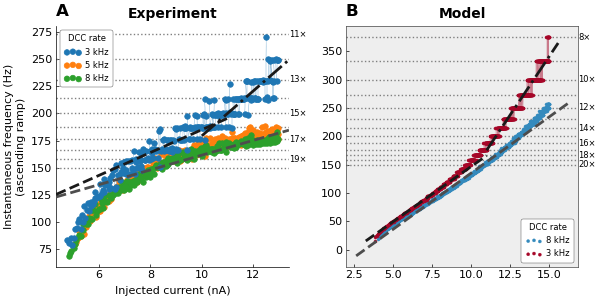

In [52]:
fig = plt.figure(figsize=(6,3), constrained_layout=True)
gs00 = matplotlib.gridspec.GridSpec(1, 2, figure=fig)
plt.style.use(['default','MM-paper',{'axes.xmargin':0.05, 'axes.ymargin':0.05}])
ax1 = fig.add_subplot(gs00[0])
ax1.set_title('Experiment')

with plt.style.context(['MM-paper','MM-model']):
    ax2 = fig.add_subplot(gs00[1])
ax2.set_title('Model')


ax = ax1
for file,freq,z in zip(
                                    ['20200707_Cell4099_002_IFCurve_DCC3kHz.txt',
                                     '20200707_Cell4099_002_IFCurve_DCC5kHz.txt',
                                     '20200707_Cell4099_002_IFCurve_DCC8kHz_5nAs.txt'],
                                   ['3 kHz','5 kHz','8 kHz'],
                                    [22,20,21]):
    df = pd.read_csv(file, sep='\t', header=0)
    df = df.loc[df.iloc[:,2]<13]
    ax.scatter(df.iloc[:,2], df.iloc[:,3], marker='o', s=4**2, lw=0.5, label=freq, zorder=z)
    ax.plot(df.iloc[:,2], df.iloc[:,3], '-', lw=0.1, zorder=z-1)
ax.set_xlabel('Injected current (nA)')
ax.set_ylabel('Instantaneous frequency (Hz)\n(ascending ramp)')
ax.legend(loc='upper left', scatterpoints=3,
          title='DCC rate')
fig.canvas.draw()
ax.autoscale(False)

df = pd.read_csv('20200707_Cell4099_002_IFCurve_DCC8kHz_5nAs.txt', sep='\t', header=0)
df = df.loc[(df.iloc[:,2]>7)&(df.iloc[:,2]<13)]
s,i,r,p,e = st.linregress(df.iloc[:,[2,3]].values.T)
print('8kHz:', s, 'Hz/nA')
x = np.array(ax.get_xlim())
y = s*x+i
ax.plot(x,y, '--', c=[.3]*3, lw=2, zorder=30)

df = pd.read_csv('20200707_Cell4099_002_IFCurve_DCC3kHz.txt', sep='\t', header=0)
df = df.loc[(df.iloc[:,2]>8)&(df.iloc[:,2]<9)]
s,i,r,p,e = st.linregress(df.iloc[:,[2,3]].values.T)
x = np.array([ax.get_xlim()[0],11])
y = s*x+i
print('3kHz:', s, 'Hz/nA')
ax.plot(x,y, '--', c='k', lw=2, zorder=30)

df = pd.read_csv('20200707_Cell4099_002_IFCurve_DCC3kHz.txt', sep='\t', header=0)
df = df.loc[(df.iloc[:,2]>11)&(df.iloc[:,2]<13)]
s,i,r,p,e = st.linregress(df.iloc[:,[2,3]].values.T)
print('3kHz:', s, 'Hz/nA')
x = np.array([10,ax.get_xlim()[1]])
y = s*x+i
ax.plot(x,y, '-.', c='k', lw=2, zorder=30)

r = range(11,21)
for d in r:
    ax.axhline(3000/d, ls=':', lw=1, c='grey', zorder=2)
for d in r[::2]:
    ax.annotate(f'{d}×', xy=(1,3000/d), xycoords=('axes fraction', 'data'),
                 ha='left', va='center', fontsize=6)


    
for (_,o),freq in zip(FI_curves_secrange.groupby('DCC_freq'),
                      ['8 kHz','3 kHz']):
    ax2.scatter(o['i'],o['freq'], 
               s=5, label=freq, zorder=z)
    ax2.plot(o['i'],o['freq'],'-', lw=0.1, zorder=z, alpha=0.5)
ax2.legend(scatterpoints=3,
          title='DCC rate')

o = FI_curves_secrange.loc[(FI_curves_secrange['DCC_freq']==3000)&
                           (FI_curves_secrange['i'].between(5,8))]
s,i,r,p,e = st.linregress(o['i'],o['freq'])
x = np.array([ax2.get_xlim()[0],11])
y = s*x+i
ax2.plot(x,y, '--', c='k', lw=2, zorder=30)

o = FI_curves_secrange.loc[(FI_curves_secrange['DCC_freq']==3000)&
                           (FI_curves_secrange['i'].between(11,15))]
s,i,r,p,e = st.linregress(o['i'],o['freq'])
x = np.array([11,ax2.get_xlim()[1]])
y = s*x+i
ax2.plot(x,y, '-.', c='k', lw=2, zorder=30)

o = FI_curves_secrange.loc[(FI_curves_secrange['DCC_freq']==0)&
                           (FI_curves_secrange['i'].between(6,13))]
s,i,r,p,e = st.linregress(o['i'],o['freq'])
x = np.array(ax2.get_xlim())
y = s*x+i
ax2.plot(x,y, '--', c=[.3]*3, lw=2, zorder=30)

r = range(8,21)
for d in r:
    ax2.axhline(3000/d, ls=':', lw=1, c='grey', zorder=2)
for d in r[::2]:
    ax2.annotate(f'{d}×', xy=(1,3000/d), xycoords=('axes fraction', 'data'),
                 ha='left', va='center', fontsize=6)

for ax,l in zip(fig.axes,
                ['A','B']):
    ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                  xytext=(0,5), textcoords='offset points',
                  ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)

plt.show()

# Mice

Number of mice

In [53]:
summary['expDate'].unique().size

7

In [54]:
summary.groupby(['expDate']).first().groupby('mouseType').size()

mouseType
B6SJL      4
C57BL/6    3
dtype: int64

In [55]:
summary.groupby('expDate').first().describe()[['mouseAge','mouseWeight']]

,mouseAge,mouseWeight
count,7.000000,7.000000
mean,104.571429,27.857143
std,66.635469,2.340126
min,49.000000,25.000000
25%,51.000000,26.000000
50%,54.000000,28.000000
75%,172.500000,29.500000
max,182.000000,31.000000


In [56]:
summary.groupby('cell').first().describe()[['electrodeR']]

,electrodeR
count,13.000000
mean,23.153846
std,5.927987
min,16.000000
25%,17.000000
50%,25.000000
75%,28.000000
max,33.000000
